# Analysis of Image Generation Techniques for Imbalananced Datasets
-- Ujjwal Asthana, Shruti Wagle, Shivani Singh

## Part - I: Installations and Imports

In [1]:
# Necessary Installations 

!pip install --upgrade diffusers transformers scipy &> /dev/null
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 19.5 MB/s eta 0:00:00


In [1]:
# Necessary Imports

import os
import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms

from NonSyntheticGeneration import NonSyntheticDataset
from StableDiffusionGeneration import StableDiffusionDataset
from ClassifierNetwork import ResNet18, ResBlock, NetTrain, NetTest
from Utils import plot_metrics, make_classification_report, plot_confusion_matrix

In [2]:
# Global Constants

SEED = 42
BATCH_SIZE = 128
EPOCHS = 50

CIFAR_10_MEANS = (0.4914, 0.4822, 0.4465)
CIFAR_10_STDS = (0.2023, 0.1994, 0.2010)

MODEL_PATH = "/content/models"
DATASET_PATH = "/content/datasets"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Setting Seeds for Reproducibility

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# Creating directories to store the model weights and datasets for different  
# generation techniques

try: 
  os.mkdir(MODEL_PATH)
  os.mkdir(DATASET_PATH)

except OSError as error: 
  print(error)

[Errno 17] File exists: '/content/models'


## Part - II: Non - Synthetic Generation

In [5]:
# Part - II: Generating Non-Synthetic Dataset (Train/Test) 


train_transform = transforms.Compose([transforms.RandomCrop(32,
                                                            padding = 4),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(), 
                          transforms.Normalize(CIFAR_10_MEANS,
                                               CIFAR_10_STDS)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(CIFAR_10_MEANS,
                                                          CIFAR_10_STDS)])

trainset = NonSyntheticDataset(root = './data', train = True, 
                               transform = train_transform,
                               download = True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True, 
                                          num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

testset = torchvision.datasets.CIFAR10(root = './data', train = False, 
                                       download = True, 
                                       transform = test_transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle = False, 
                                         num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Defining function to initialize the neural network

def init_network():

  criterion = nn.CrossEntropyLoss()

  net = ResNet18(3, ResBlock, outputs = 10)
  net.to(DEVICE) 

  optimizer = optim.SGD(net.parameters(), lr = 0.2, momentum = 0.0005, 
                        weight_decay = 5e-4)
    
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max = EPOCHS)

  return net, criterion, optimizer, scheduler 

In [7]:
# Initializing ResNet18 for Non - Synthetic Generation

net, criterion, optimizer, scheduler = init_network()

In [8]:
# Training the ResNet18 for Non - Synthetic Generation

best_acc = 0
best_epoch = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  print(f'Epoch {epoch + 1} :')

  train_loss, train_acc = NetTrain(net, trainloader, DEVICE, optimizer, 
                                criterion)
  
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  print("Train Loss = " + str(train_loss) + "\t" + "Train Accuracy = " + 
        str(train_acc))

  test_loss , test_acc, predictions, labels = NetTest(net, testloader,
                                                      DEVICE, criterion)
  
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  
  print("Test Loss = " + str(test_loss) + "\t" + "Test Accuracy = " + 
        str(test_acc))


  if test_acc > best_acc:
    best_acc = test_acc
    best_epoch = epoch

    torch.save(net.state_dict(), 
               '/content/models/resnet_non_synthetic.pt')
  
  print("Best Test Accuracy = " + str(best_acc) + "\n")
  scheduler.step()

Epoch 1 :
Train Loss = 1.5296552205634544	Train Accuracy = 44.412
Test Loss = 8.77321505244774	Test Accuracy = 24.56
Best Test Accuracy = 24.56

Epoch 2 :
Train Loss = 0.9551220723735098	Train Accuracy = 66.092
Test Loss = 1.499750169017647	Test Accuracy = 62.42
Best Test Accuracy = 62.42

Epoch 3 :
Train Loss = 0.6757539701278862	Train Accuracy = 76.452
Test Loss = 1.7031542092938967	Test Accuracy = 58.64
Best Test Accuracy = 62.42

Epoch 4 :
Train Loss = 0.5433486206147372	Train Accuracy = 81.638
Test Loss = 1.4585804652564134	Test Accuracy = 67.01
Best Test Accuracy = 67.01

Epoch 5 :
Train Loss = 0.46659945793773816	Train Accuracy = 84.098
Test Loss = 1.3850832958764667	Test Accuracy = 68.13
Best Test Accuracy = 68.13

Epoch 6 :
Train Loss = 0.41603702680229226	Train Accuracy = 85.872
Test Loss = 1.2543820542625235	Test Accuracy = 71.87
Best Test Accuracy = 71.87

Epoch 7 :
Train Loss = 0.37071847343993614	Train Accuracy = 87.312
Test Loss = 1.0733541642563253	Test Accuracy = 76.6


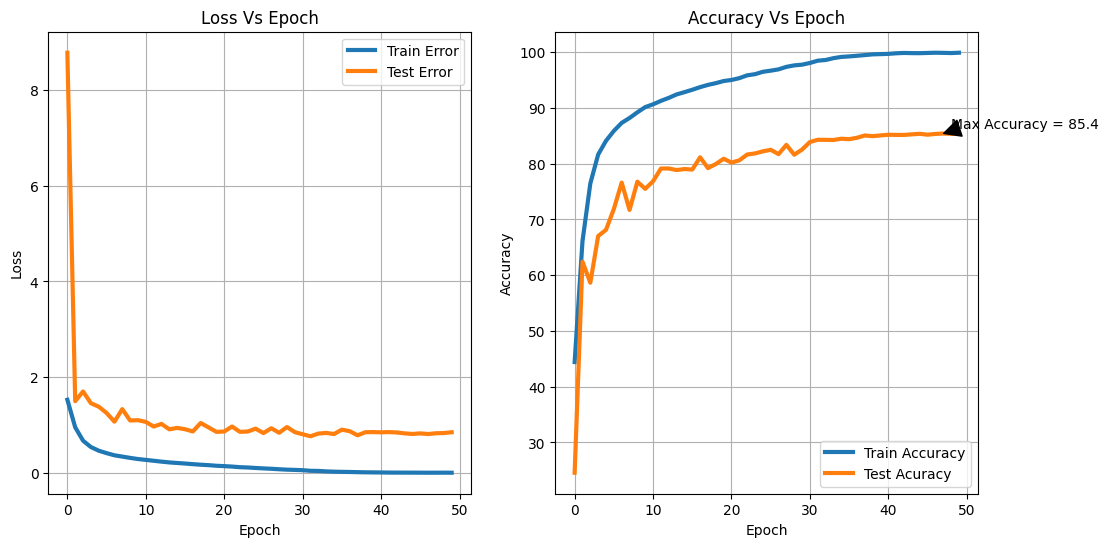

In [9]:
# Plotting Losses and Accuracies for Non - Synthetic Generation 

plot_metrics(train_accs, test_accs, train_losses, test_losses, best_epoch, best_acc)

In [10]:
# Making Classification Report 

net, criterion, optimizer, scheduler = init_network()
net.load_state_dict(torch.load('/content/models/resnet_non_synthetic.pt'))

test_loss , test_acc, predictions, labels = NetTest(net, testloader, DEVICE, criterion)

print(make_classification_report(labels, predictions, target_names = testset.classes))

              precision    recall  f1-score   support

    airplane       0.92      0.94      0.93      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.82      0.91      0.86      1000
         cat       1.00      0.03      0.05      1000
        deer       0.85      0.94      0.89      1000
         dog       0.61      0.93      0.74      1000
        frog       0.85      0.96      0.90      1000
       horse       0.90      0.95      0.93      1000
        ship       0.94      0.96      0.95      1000
       truck       0.94      0.96      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.88      0.85      0.82     10000
weighted avg       0.88      0.85      0.82     10000



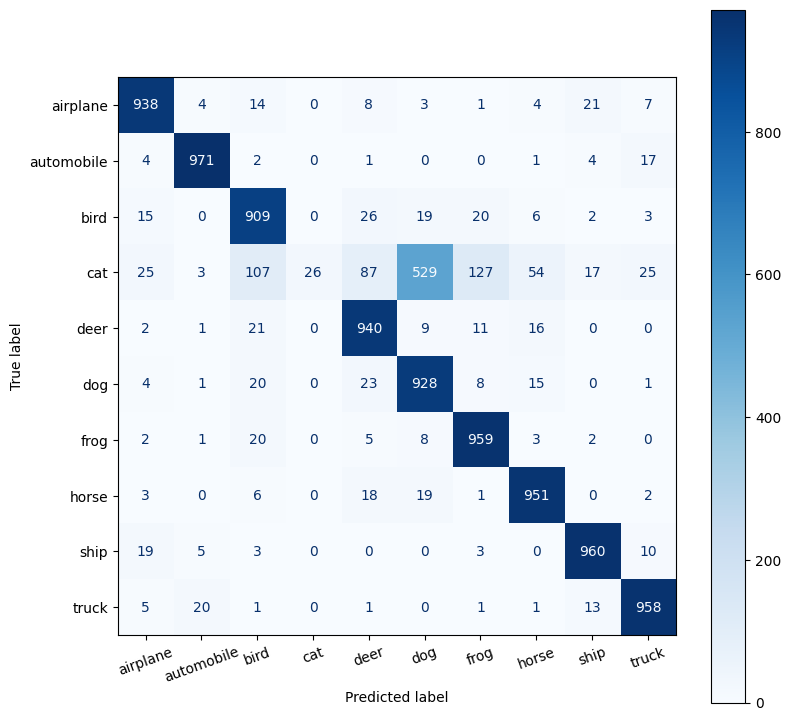

In [11]:
# Plotting Confusion Matrix

plot_confusion_matrix(labels, predictions, testset.classes)

## Part - IV: Stable Diffusion Generation

In [14]:
# Stable Diffusion Dataset Generation using Textual Prompts

# Output is captured because Javascript fails in Colab when it has to
# display the stable diffusion progress bar animations for almost 5000
# entries

%%capture 

train_transform = transforms.Compose([transforms.RandomCrop(32,
                                                            padding = 4),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(), 
                          transforms.Normalize(CIFAR_10_MEANS,
                                               CIFAR_10_STDS)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(CIFAR_10_MEANS,
                                                          CIFAR_10_STDS)])

trainset = StableDiffusionDataset(root = './data', train = True, 
                               transform = train_transform,
                               download = True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True, 
                                          num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

testset = torchvision.datasets.CIFAR10(root = './data', train = False, 
                                       download = True, 
                                       transform = test_transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = BATCH_SIZE,
                                         shuffle = False, 
                                         num_workers = 2, 
                                    worker_init_fn = np.random.seed(SEED))

In [15]:
# Initializing ResNet18 for Stable Diffusion Generation

net, criterion, optimizer, scheduler = init_network()

In [ ]:
# Training the ResNet18 for Stable Diffusion Generation

best_acc = 0
best_epoch = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  print(f'Epoch {epoch + 1} :')

  train_loss, train_acc = NetTrain(net, trainloader, DEVICE, optimizer, 
                                criterion)
  
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  print("Train Loss = " + str(train_loss) + "\t" + "Train Accuracy = " + 
        str(train_acc))

  test_loss , test_acc, predictions, labels = NetTest(net, testloader,
                                                      DEVICE, criterion)
  
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  
  print("Test Loss = " + str(test_loss) + "\t" + "Test Accuracy = " + 
        str(test_acc))


  if test_acc > best_acc:
    best_acc = test_acc
    best_epoch = epoch

    torch.save(net.state_dict(), 
               '/content/models/resnet_stable_diffusion.pt')
  
  print("Best Test Accuracy = " + str(best_acc) + "\n")
  scheduler.step()

Epoch 1 :
Train Loss = 1.589619823733864	Train Accuracy = 42.238
Test Loss = 1.6179078907906255	Test Accuracy = 46.79
Best Test Accuracy = 46.79

Epoch 2 :
Train Loss = 1.003743106904237	Train Accuracy = 64.372
Test Loss = 1.4247504306744925	Test Accuracy = 57.82
Best Test Accuracy = 57.82

Epoch 3 :
Train Loss = 0.7137434215801756	Train Accuracy = 75.476
Test Loss = 1.3336452170263362	Test Accuracy = 64.73
Best Test Accuracy = 64.73

Epoch 4 :
Train Loss = 0.5707656746477727	Train Accuracy = 80.44
Test Loss = 1.7069946195505843	Test Accuracy = 58.38
Best Test Accuracy = 64.73

Epoch 5 :
Train Loss = 0.4851534352125719	Train Accuracy = 83.436
Test Loss = 1.0672064891344384	Test Accuracy = 71.19
Best Test Accuracy = 71.19

Epoch 6 :
Train Loss = 0.4288732745229741	Train Accuracy = 85.526
Test Loss = 1.081055193762236	Test Accuracy = 75.33
Best Test Accuracy = 75.33

Epoch 7 :
Train Loss = 0.3846787350714359	Train Accuracy = 86.9
Test Loss = 0.823210410679443	Test Accuracy = 77.49
Best T

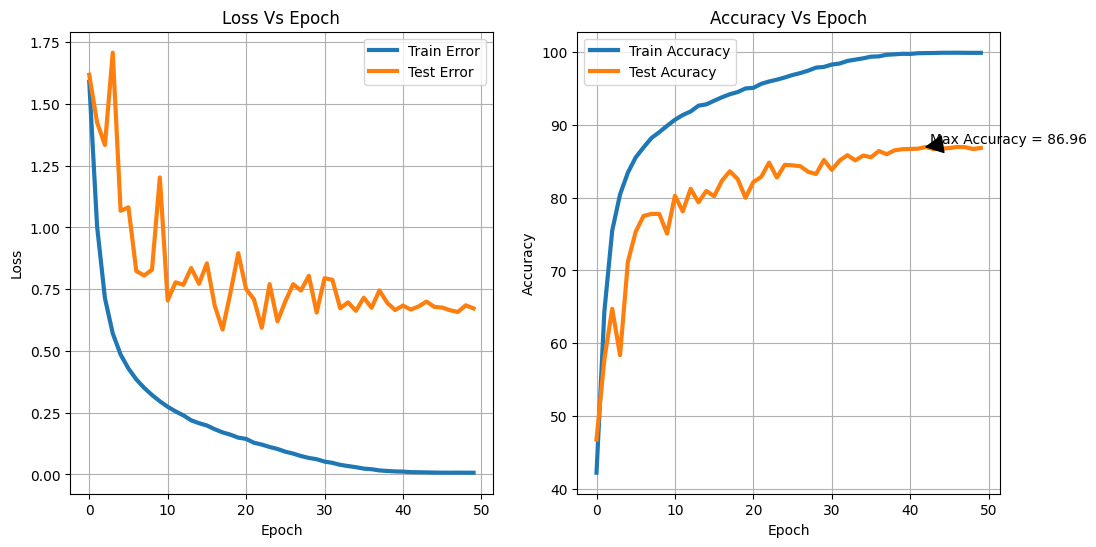

In [ ]:
plot_metrics(train_accs, test_accs, train_losses, test_losses, best_epoch, best_acc)

In [ ]:
# Making Classification Report 

net, criterion, optimizer, scheduler = init_network()
net.load_state_dict(torch.load('/content/models/resnet_stable_diffusion.pt'))

test_loss , test_acc, predictions, labels = NetTest(net, testloader, DEVICE, criterion)

print(make_classification_report(labels, predictions, target_names = testset.classes))

              precision    recall  f1-score   support

    airplane       0.90      0.94      0.92      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.87      0.89      0.88      1000
         cat       0.95      0.21      0.35      1000
        deer       0.84      0.93      0.89      1000
         dog       0.64      0.94      0.76      1000
        frog       0.86      0.95      0.90      1000
       horse       0.94      0.95      0.95      1000
        ship       0.95      0.95      0.95      1000
       truck       0.93      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.89      0.87      0.85     10000
weighted avg       0.89      0.87      0.85     10000



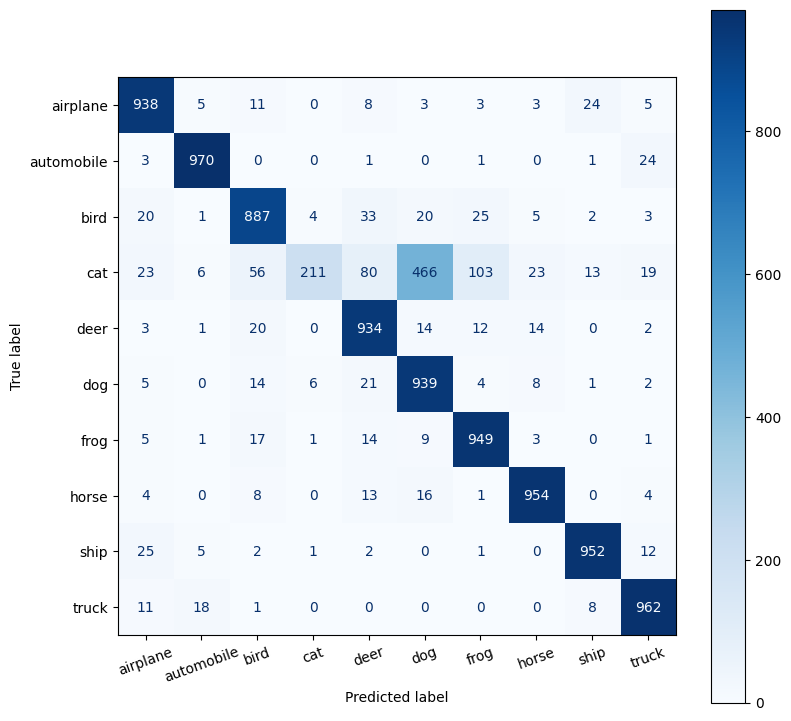

In [ ]:
# Plotting Confusion Matrix

plot_confusion_matrix(labels, predictions, testset.classes)